In [1]:
import os
import json
import torch
import numpy as np
import PIL
from PIL import Image
from IPython.display import HTML
from pyramid_dit import PyramidDiTForVideoGeneration
from IPython.display import Image as ipython_image
from diffusers.utils import load_image, export_to_video, export_to_gif

/home/sxk230060/miniconda3/envs/pyramid/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
variant='diffusion_transformer_384p'       # For low resolution variant
# variant='diffusion_transformer_768p'     # For high resolution variant

model_name = "pyramid_mmdit"   # select the model "pyramid_flux" or "pyramid_mmdit"

model_path = "/mnt/sda1/saksham/TI2AV/pyramid/"  # The downloaded checkpoint dir
model_dtype = 'bf16'

device_id = 1
torch.cuda.set_device(device_id)

model = PyramidDiTForVideoGeneration(
    model_path,
    model_dtype,
    model_name=model_name,
    model_variant=variant,
)

model.vae.to("cuda")
model.dit.to("cuda")
model.text_encoder.to("cuda")

model.vae.enable_tiling()

if model_dtype == "bf16":
    torch_dtype = torch.bfloat16 
elif model_dtype == "fp16":
    torch_dtype = torch.float16
else:
    torch_dtype = torch.float32


def resize_crop_image(img: PIL.Image.Image, tgt_width, tgt_height):
    ori_width, ori_height = img.width, img.height
    scale = max(tgt_width / ori_width, tgt_height / ori_height)
    resized_width = round(ori_width * scale)
    resized_height = round(ori_height * scale)
    img = img.resize((resized_width, resized_height), resample=PIL.Image.LANCZOS)

    left = (resized_width - tgt_width) / 2
    top = (resized_height - tgt_height) / 2
    right = (resized_width + tgt_width) / 2
    bottom = (resized_height + tgt_height) / 2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    
    return img


def show_video(ori_path, rec_path, width="100%"):
    html = ''
    if ori_path is not None:
        html += f"""<video controls="" name="media" data-fullscreen-container="true" width="{width}">
        <source src="{ori_path}" type="video/mp4">
        </video>
        """
    
    html += f"""<video controls="" name="media" data-fullscreen-container="true" width="{width}">
    <source src="{rec_path}" type="video/mp4">
    </video>
    """
    return HTML(html)

Using temporal causal attention
We interp the position embedding of condition latents


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


The start sigmas and end sigmas of each stage is Start: {0: 1.0, 1: 0.8002399489209289, 2: 0.5007496155411024}, End: {0: 0.6669999957084656, 1: 0.33399999141693115, 2: 0.0}, Ori_start: {0: 1.0, 1: 0.6669999957084656, 2: 0.33399999141693115}


#### Text-to-Video

In [ ]:
prompt = "A person playing violin fiddle in the dark"
# prompt ='playing violin fiddle'
# used for 384p model variant
width = 640
height = 384

# used for 768p model variant
# width = 1280
# height = 768

temp = 16   # temp in [1, 31] <=> frame in [1, 241] <=> duration in [0, 10s]
# Noting that, for the 384p version, only supports maximum 5s generation (temp = 16)

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True if model_dtype != 'fp32' else False, dtype=torch_dtype):
    frames = model.generate(
        prompt=prompt,
        num_inference_steps=[20, 20, 20],
        video_num_inference_steps=[10, 10, 10],
        height=height,
        width=width,
        temp=temp,
        guidance_scale=7.0,         # The guidance for the first frame, set it to 7 for 384p variant
        video_guidance_scale=5.0,   # The guidance for the other video latent
        output_type="pil",
        save_memory=True,           # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

export_to_video(frames, "./text_to_video_sample.mp4", fps=24)
show_video(None, "./text_to_video_sample.mp4", "70%")

100%|██████████| 16/16 [01:50<00:00,  6.93s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

#### Image-to-Video

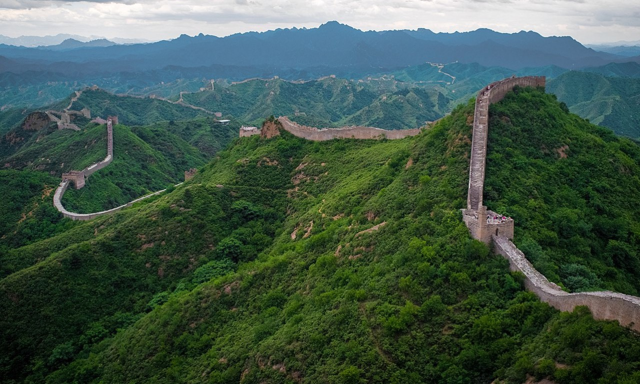

100%|██████████| 15/15 [01:19<00:00,  5.27s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

In [3]:
image_path = 'assets/the_great_wall.jpg'
image = Image.open(image_path).convert("RGB")

# used for 384p model variant
width = 640
height = 384

# used for 768p model variant
# width = 1280
# height = 768

temp = 16
image = image.resize((width, height))
image = resize_crop_image(image, width, height)

display(image)

prompt = "FPV flying over the Great Wall"

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True if model_dtype != 'fp32' else False, dtype=torch_dtype):
    frames = model.generate_i2v(
        prompt=prompt,
        input_image=image,
        num_inference_steps=[10, 10, 10],
        temp=temp,
        guidance_scale=7.0,
        video_guidance_scale=4.0,
        output_type="pil",
        save_memory=True,         # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

export_to_video(frames, "./image_to_video_sample.mp4", fps=24)
show_video(None, "./image_to_video_sample.mp4", "70%")